In [1]:
%load_ext autoreload
%autoreload 2

from scoresbibm.utils.data_utils import save_model, load_model, save_summary, query
import jax
import jax.numpy as jnp
rng_seed_for_training = 42 
master_rng_key = jax.random.PRNGKey(rng_seed_for_training)

In [2]:
def load_full_model(dir_path, model_id, simulator=None):
    from simformer import GalaxyPrior
    from joblib import load
    from scoresbibm.utils.edge_masks import get_edge_mask_fn
    from scoresbibm.tasks import get_task


    model = load_model(
        dir_path=dir_path,
        model_id=model_id,
    )
    
    try:

        meta = load(f"{dir_path}/models/data_{model_id}.joblib")

        model.__dict__.update(meta)
        task_name = model.edge_mask_fn_params.get("task")
        task = get_task(task_name)
        task.__dict__.update(meta)

        task.prior_dist = GalaxyPrior(prior_ranges=task.prior_dict, param_order=task.param_names_ordered)

        model.edge_mask_fn = get_edge_mask_fn(
                model.edge_mask_fn_params["name"], task
        )

        #print('Disregard previous warnings, param_names, num_filters and priors have been set.')


        if simulator is not None:
            model.simulator = simulator
        else:
            print("No simulator provided. Please provide a simulator to use with the model.")
    except FileNotFoundError:
        pass
    
    return model

In [3]:
reloaded_model = load_full_model(
    dir_path='/home/tharvey/work/ltu-ili_testing/models/simformer/',
    model_id='simformer_galaxy_score_model_test_v1',
)

/home/tharvey/work/simformer/simformer_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No simulator provided. Please provide a simulator to use with the model.


In [4]:
x = [236.549,  83.717,  37.53 ,  36.727,  36.302,  36.072,  35.91,
        35.483,  35.272,  35.114,  34.698,  34.554,  34.172,  33.674]
theta = [ 11.181,   8.2  ,  -2.267,   1.957, 452.194, 823.456,   0.531]
theta_dim = len(theta)
x_dim = len(x)

x_o = jnp.array([x], dtype=jnp.float32)

posterior_condition_mask = jnp.array([0]*theta_dim + [1]*reloaded_model._x_dim, dtype=jnp.bool_)

samples=reloaded_model.sample_batched(num_samples=1000, x_o=x_o, condition_mask=posterior_condition_mask, rng=master_rng_key)

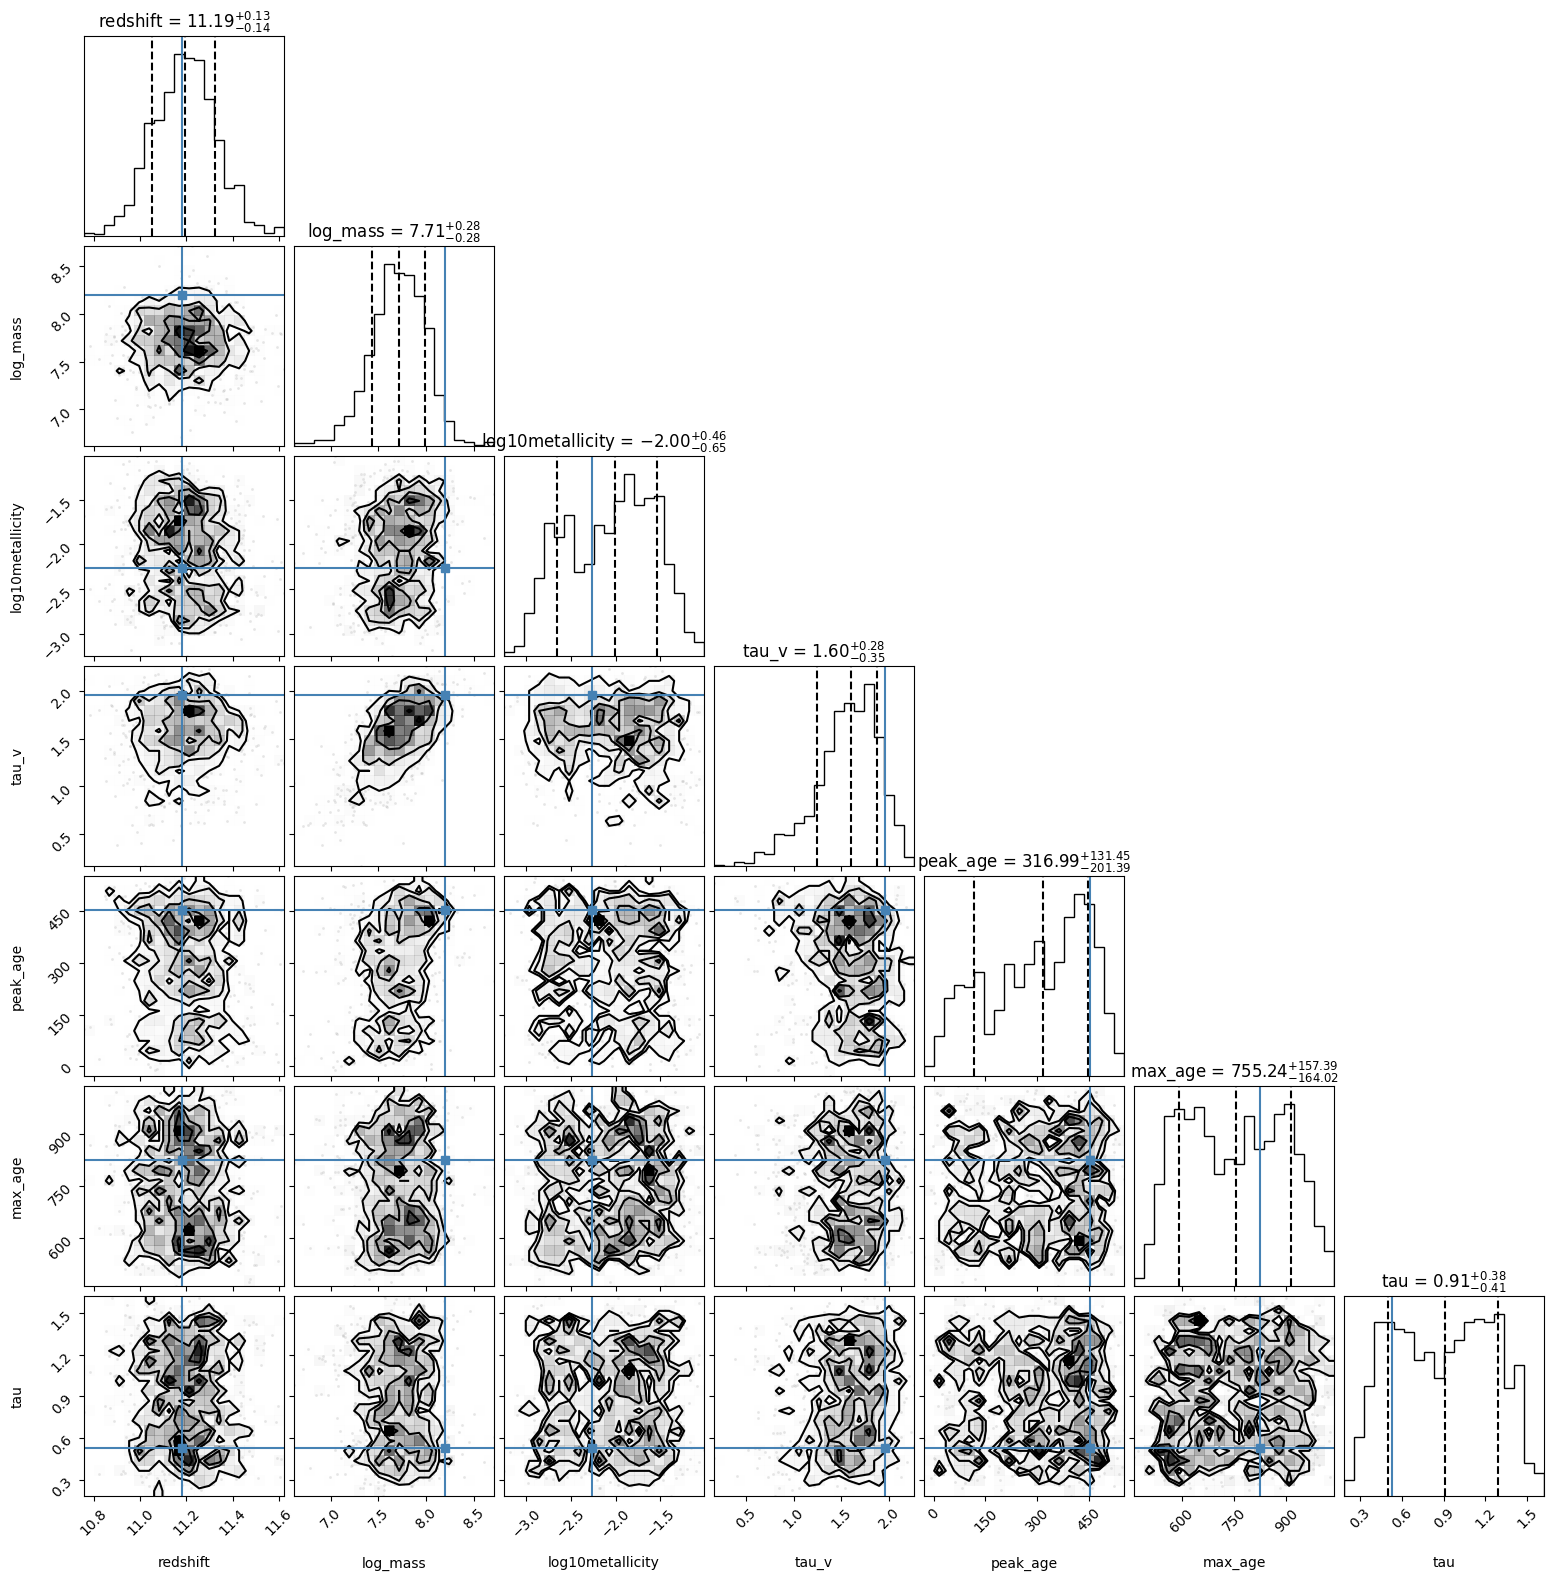

In [5]:
import corner
import numpy as np

samples = np.array(samples, dtype=np.float32)

corner.corner(samples, labels=reloaded_model.param_names_ordered, show_titles=True,
                truths=theta, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 12});

In [47]:
filter_codes = ["JWST/NIRCam.F090W","JWST/NIRCam.F115W","JWST/NIRCam.F150W","JWST/NIRCam.F162M",
                "JWST/NIRCam.F182M","JWST/NIRCam.F200W","JWST/NIRCam.F210M","JWST/NIRCam.F250M",
                "JWST/NIRCam.F277W","JWST/NIRCam.F300M","JWST/NIRCam.F335M","JWST/NIRCam.F356W",
                "JWST/NIRCam.F410M","JWST/NIRCam.F444W"]

x = np.array([236.549,  83.717,  37.53,  36.727,  36.302,  36.072,  35.91,
        35.483,  35.272,  35.114,  34.698,  34.554,  34.172,  33.674])
theta = [ 11.181,   8.2  ,  -2.267,   1.957, 452.194, 823.456,   0.531]

mask = [0 if code.endswith('W') else 1 for code in filter_codes]
mask_bool = np.array(mask, dtype=np.bool_)

x = x[~mask_bool]
x = jnp.array([x], dtype=jnp.float32)
# sample missing photometry as well
posterior_condition_mask = jnp.array([0]*theta_dim + mask, dtype=jnp.bool_)

samples_nomedium=reloaded_model.sample_batched(num_samples=1000, x_o=x, condition_mask=posterior_condition_mask, rng=master_rng_key)

samples_nomedium = np.array(samples_nomedium[0], dtype=np.float32)

theta_samples = samples_nomedium[:, :theta_dim]
phot_samples = samples_nomedium[:, theta_dim:]

In [48]:
x

Array([[236.549,  83.717,  37.53 ,  36.072,  35.272,  34.554,  33.674]],      dtype=float32)

Corner plot with both

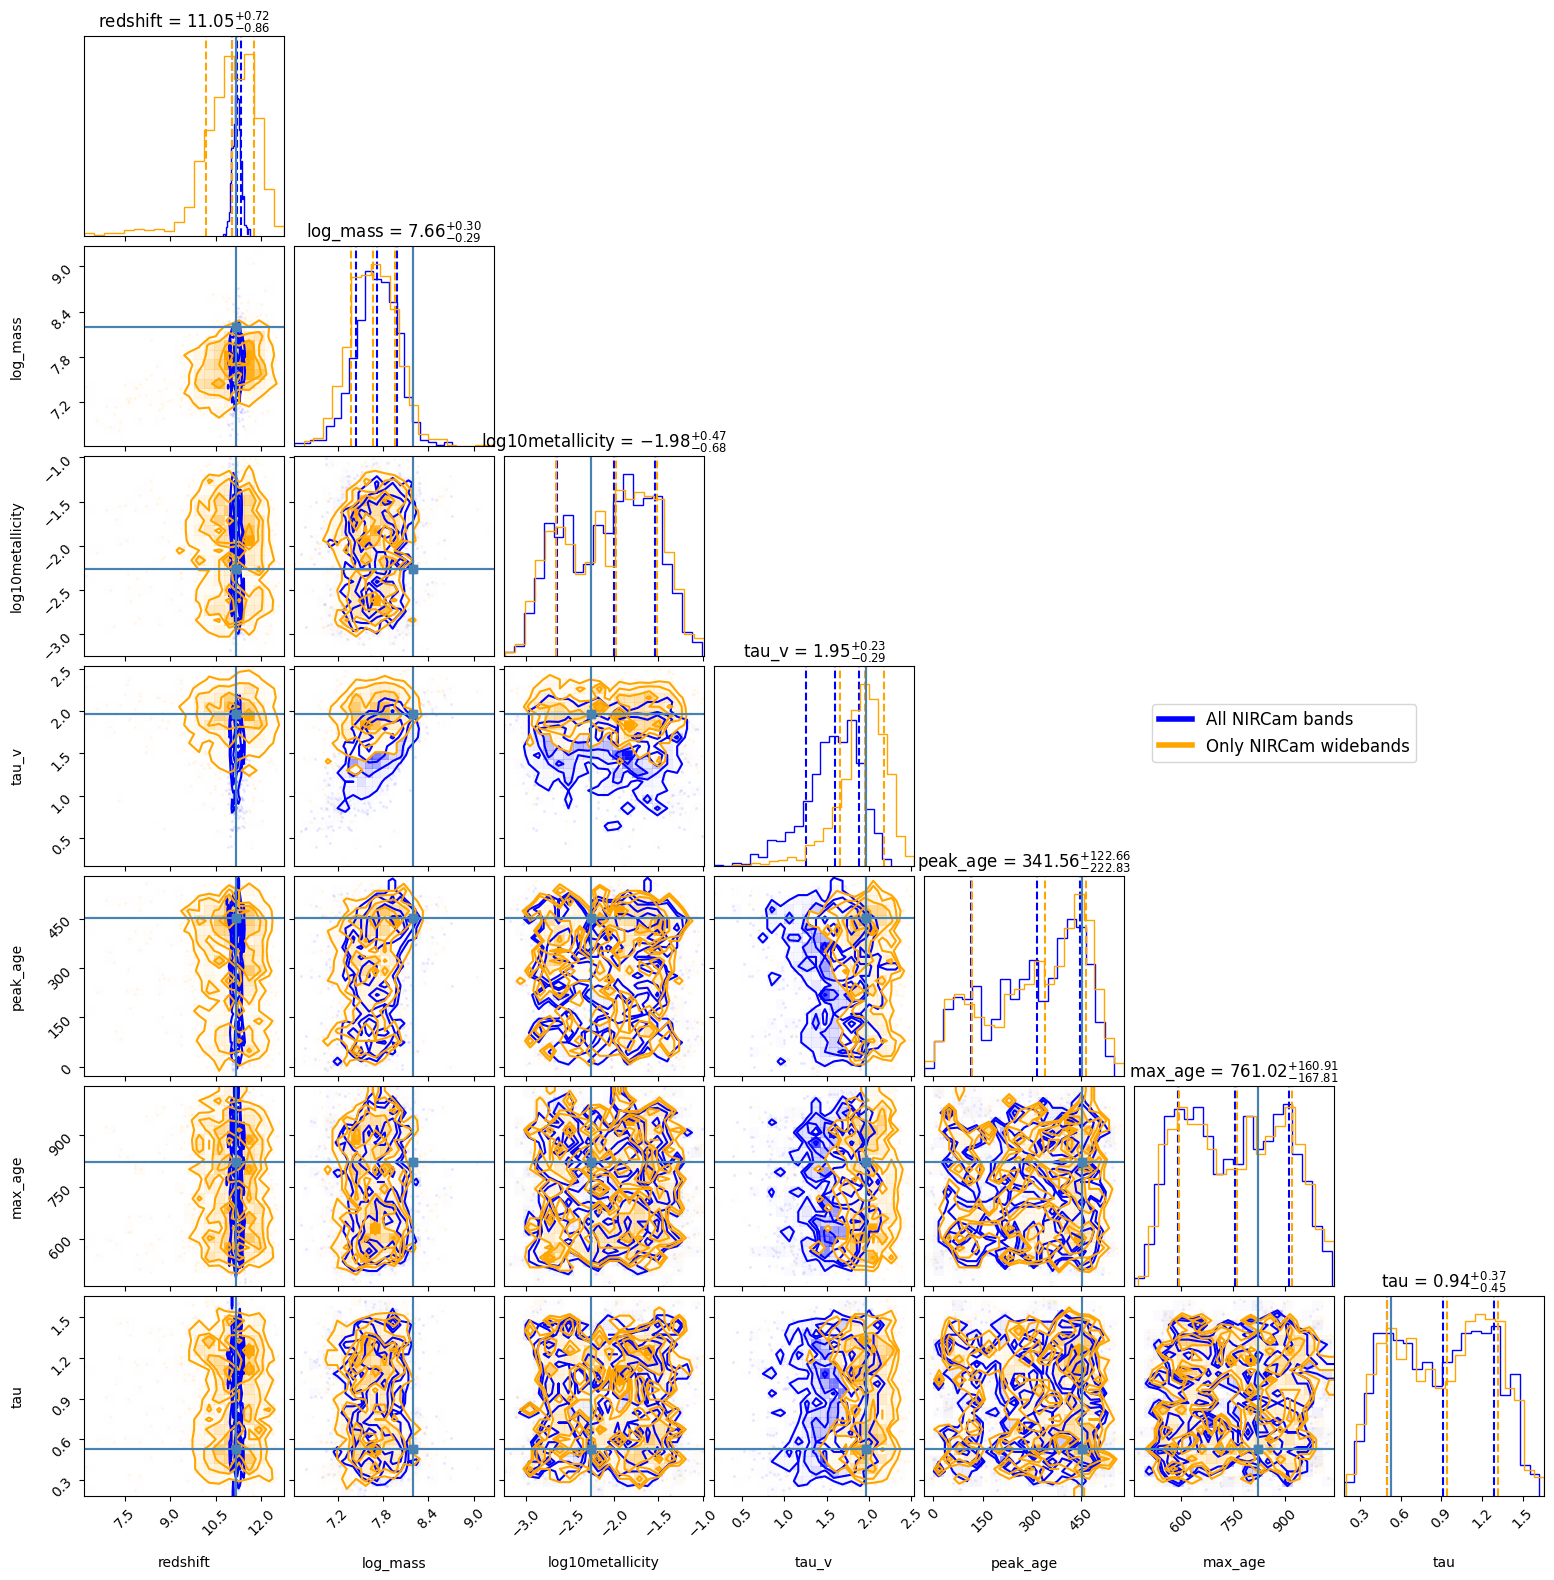

In [42]:
samples_nomedium = np.array(samples_nomedium, dtype=np.float32)

fig = corner.corner(samples, labels=reloaded_model.param_names_ordered, show_titles=True,
                truths=theta, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 12}, color="blue", label="Full samples");
# add medium samples
corner.corner(theta_samples, labels=reloaded_model.param_names_ordered, show_titles=True,
                truths=theta, quantiles=[0.16, 0.5, 0.84], title_kwargs={"fontsize": 12}, fig=fig, color="orange");

# Add mock label with orange and blue

import matplotlib.pyplot as plt

plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=4, label='All NIRCam bands'),
                    plt.Line2D([0], [0], color='orange', lw=4, label='Only NIRCam widebands')],
              bbox_to_anchor=(-1, 4), loc='upper left', fontsize=12)
#plt.title("Posterior samples with and without medium photometry", fontsize=14)
plt.show()

array([224.077, 160.144, 374.8  , 147.46 , 265.611, 243.089, 174.92 ,
       294.88 , 268.61 , 369.112, 296.027, 118.998, 210.917, 337.94 ,
       134.094, 374.399,  69.129, 285.817, 134.113, 324.859, 362.538,
       225.825, 209.019, 159.83 , 215.803, 193.471, 324.758, 395.945,
       325.245, 171.377, 177.572, 304.404, 219.447, 140.048, 230.37 ,
       252.078, 323.319, 269.596, 298.453, 305.73 , 191.864, 386.932,
       171.106, 296.973, 118.849, 104.095, 109.958, 394.681, 284.885,
       275.443, 212.992, 183.49 , 193.341, 152.394, 254.678, 223.507,
       170.461, 470.004, 132.787, 336.687, 330.349, 120.488, 195.439,
       153.684, 272.991, 187.591, 303.926, 274.28 , 166.155, 330.791,
       187.865, 135.447, 111.155,  53.241, 353.01 , 131.378, 184.997,
        93.872,  86.814, 290.87 , 117.695, 258.401, 216.29 , 223.2  ,
       199.32 , 194.178, 375.141, 295.565, 316.046, 302.212,  88.004,
        59.637, 226.372, 201.851, 129.68 ,  93.691, 318.765, 206.683,
       301.329, 347.

[36.727 36.302 35.91  35.483 35.114 34.698 34.172]
1000
1000
1000
1000
1000
1000
1000


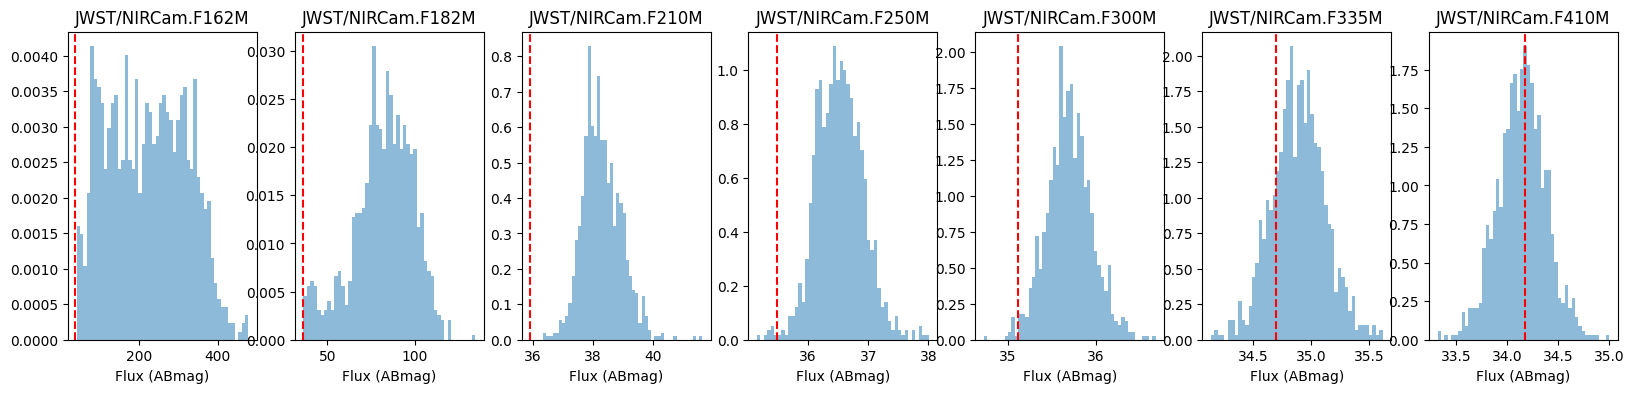

In [56]:
x = np.array([236.549,  83.717,  37.53,  36.727,  36.302,  36.072,  35.91,
        35.483,  35.272,  35.114,  34.698,  34.554,  34.172,  33.674])

missing_phot = np.array(x)[mask_bool]

print(missing_phot)

missing_phot_names = np.array(filter_codes)[mask_bool]
fig, axes= plt.subplots(1, len(missing_phot), figsize=(20, 4))
for i, ax in enumerate(axes):
    (1, 1000, 7)
    samples_i = phot_samples[:, i]
    print(len(samples_i))
    ax.hist(samples_i, bins=50, density=True, alpha=0.5, label=f"Posterior samples for {missing_phot_names[i]}")
    ax.set_title(f"{missing_phot_names[i]}")
    ax.axvline(x=missing_phot[i], color='red', linestyle='--', label='True value')
    #ax.set_xlim([missing_phot[i] - 0.5, missing_phot[i] + 0.5])
    ax.set_xlabel("Flux (ABmag)")



In [ ]:
samples_nomedium.shape

(1, 1000, 14)